# **Análisis de mercado de restaurantes en LA.**

**Descripción de datos `rest_data`:** 

* `object_name` — nombre del establecimiento
* `chain` — establecimiento que pertenece a una cadena (TRUE/FALSE)
* `object_type` — tipo de establecimiento
* `address` — dirección
* `number` — número de asientos

Lo que haremos en este proyecto es analizar los datos del dataframe que está descrito arriba y una presentación para el equipo de inversionistas.

## **Carga y preparación de datos**

In [1]:
!pip install -q usaddress

     |████████████████████████████████| 63 kB 814 kB/s 
     |████████████████████████████████| 1.0 MB 13.8 MB/s 


Esta parte de código es un parser para las addresses en Estados Unidos, se encarga de hacer el breakdown de las partes de una dirección y tomar ciertas partes de la misma o separarla para usarlas después. La vamos a necesitar para analizar nuestros datos de acuerdo a su locación, lo pondremos aquí junto con nuestras librerías.

In [2]:
import pandas   as pd
import datetime as dt
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import usaddress
import plotly.express as px

In [3]:
rest_data = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data_us.csv')
rest_data.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [4]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


Aquí tenemos las columnas y el número de filas que tenemos en el dataframe, 6 columnas y 9651 filas.

In [5]:
rest_data = rest_data.rename(columns = {'object_name':'name','object_type':'type'})
rest_data.tail()

,id,name,address,chain,type,number
9646,21432,HALL OF JUSTICE,217 W TEMPLE AVE,False,Restaurant,122
9647,21433,FIN-MELROSE,5750 MELROSE AVE,False,Restaurant,93
9648,21434,JUICY WINGZ,6741 HOLLYWOOD BLVD,True,Fast Food,15
9649,21435,MEDIDATE COFFEE,548 S SPRING ST STE 100,False,Cafe,6
9650,21436,CAFE SPROUTS,1300 S SAN PEDRO ST STE 111,True,Restaurant,19


In [6]:
def create_clear_column(df, cols):
    for col in cols:
        df[col+'_clean'] = df[col].str.lower()
        df[col+'_clean'] = df[col+'_clean'].replace('[^a-zA-Z0-9 ]', '', regex=True)
    return df
cols = ['name', 'address']
rest_data = create_clear_column(rest_data, cols) # Creamos una nueva columna con las direcciones de los establecimientos pero en lower str y sin símbolos extra

In [7]:
rest_data[['name_clean', 'address_clean']].duplicated().sum() # Tenemos duplicados

29

In [8]:
rest_data = rest_data.sort_values(by = 'id', ascending = True)
rest_data.drop_duplicates(subset=['name_clean','address_clean'], keep= 'last', inplace=True) # Pero ya no

In [9]:
rest_data[['name_clean', 'address_clean']].duplicated().sum()

0

In [10]:
def fill_nan(selection):    
    return len(selection) > 1

rest_data['chain'] = rest_data['chain'].fillna(
    rest_data.
    groupby(['name'])['chain'].
    transform(fill_nan)
)
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9622 entries, 0 to 9650
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             9622 non-null   int64 
 1   name           9622 non-null   object
 2   address        9622 non-null   object
 3   chain          9622 non-null   bool  
 4   type           9622 non-null   object
 5   number         9622 non-null   int64 
 6   name_clean     9622 non-null   object
 7   address_clean  9622 non-null   object
dtypes: bool(1), int64(2), object(5)
memory usage: 610.8+ KB


In [11]:
rest_with_small_number_seats = ( 
    rest_data.
    pivot_table(index = 'number', values = 'id', aggfunc = 'count').reset_index()
)
rest_with_small_number_seats.head()

,number,id
0,1,186
1,2,177
2,3,191
3,4,173
4,5,197


## **Análisis de datos**

### **1. Proporciones de los distintos tipos de establecimientos**

In [12]:
rest_types = rest_data.groupby('type',as_index = False).agg({'id':'count'})
rest_types = rest_types.rename(columns = {'id':'count'})
rest_types

,type,count
0,Bakery,283
1,Bar,292
2,Cafe,434
3,Fast Food,1063
4,Pizza,315
5,Restaurant,7235


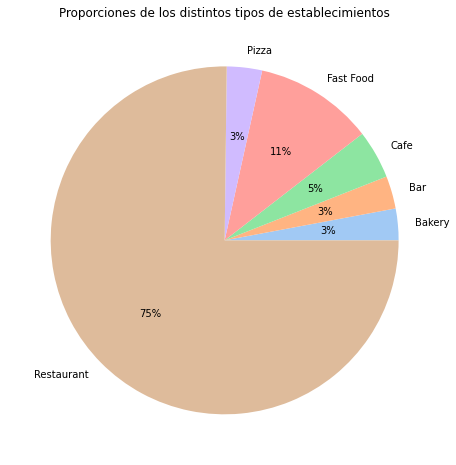

In [13]:
labels = ['Bakery', 'Bar', 'Cafe', 'Fast Food', 'Pizza', 'Restaurant']
figure(figsize=(15, 8))
colors = sns.color_palette('pastel')
plt.title('Proporciones de los distintos tipos de establecimientos')
plt.pie(rest_types['count'], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

En esta sección del análisis observamos la proporción y la distribución de los establecimientos por su tipo de acuerdo con la cantidad de establecimientos que tenemos de cada uno en el dataframe.

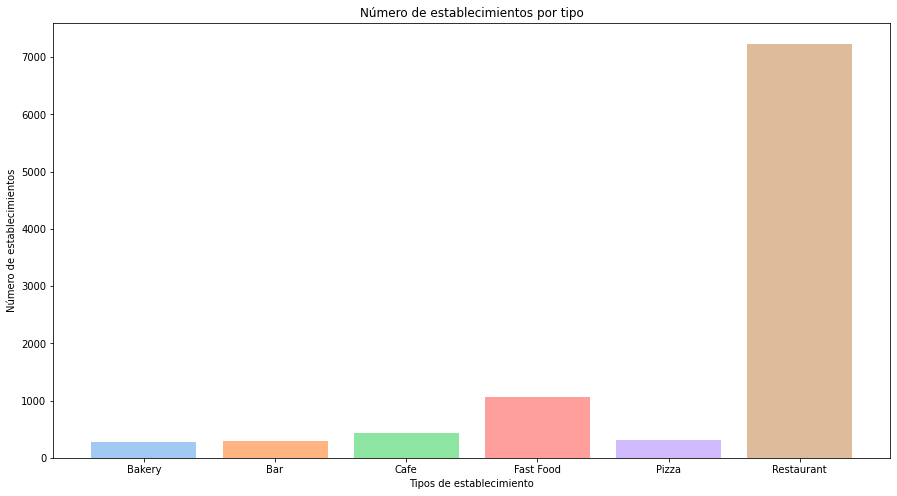

In [14]:
figure(figsize=(15, 8))
plt.title('Número de establecimientos por tipo')
plt.xlabel('Tipos de establecimiento')
plt.ylabel('Número de establecimientos')
plt.bar(rest_types['type'], rest_types['count'], color=colors)
plt.show()

### **2. Proporciones de los establecimientos que pertenecen a una cadena y de los que no** 

In [15]:
rest_chain = ( 
    rest_data.groupby('chain',as_index = False).
    agg({'id':'count'}).
    sort_values(by = 'chain', ascending = False)
)
rest_chain = rest_chain.rename(columns = {'id':'count'})
rest_chain

,chain,count
1,True,3657
0,False,5965


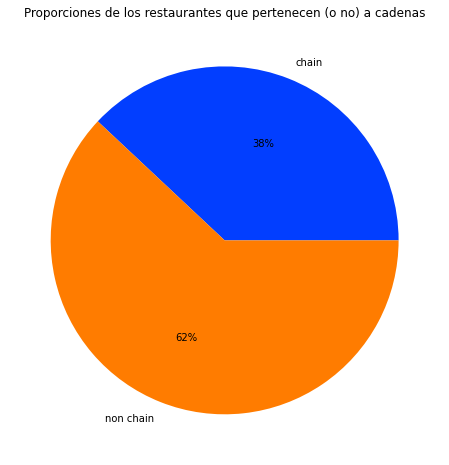

In [16]:
labels = ['chain', 'non chain']
figure(figsize=(15, 8))
colors = sns.color_palette('bright')
plt.title('Proporciones de los restaurantes que pertenecen (o no) a cadenas')
plt.pie(rest_chain['count'], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

En esta gráfica se aprecia la proporción que hay en el dataframe de restaurantes que pertenecen a una cadena (62%) y los que no (38%).

### **3. ¿Qué tipo de establecimiento es habitualmente una cadena?**

In [17]:
print('El número de restaurantes únicos que sí pertenecen a una cadena es:',rest_data[rest_data['chain'] == True].agg({'name' : 'nunique'}))

El número de restaurantes únicos que sí pertenecen a una cadena es: name    2728
dtype: int64


In [18]:
print('El número de asientos en restaurantes que no pertenecen a una cadena es {:}'.format(rest_data[rest_data['chain'] == False]['number'].mean()))
print('El número de asientos en restaurantes que sí pertenecen a una cadena es {:}'.format(rest_data[rest_data['chain'] == True]['number'].mean()))

El número de asientos en restaurantes que no pertenecen a una cadena es 46.13679798826488
El número de asientos en restaurantes que sí pertenecen a una cadena es 39.79682800109379


En promedio, los restaurantes que pertenecen a una cadena tienen menos asientos que los que no, con algunas excepciones por supuesto. Mientras que los establecimientos independientes tienen más asientos.

In [19]:
chain_pl = rest_data.pivot_table(index='type', values='name', columns='chain', aggfunc='count').reset_index().fillna(0)
chain_pl.columns =('type','no', 'yes')
chain_pl # Aquí tenemos cuantos establecimientos de cada ipo son cadena y no

,type,no,yes
0,Bakery,0.0,283.0
1,Bar,215.0,77.0
2,Cafe,168.0,266.0
3,Fast Food,460.0,603.0
4,Pizza,167.0,148.0
5,Restaurant,4955.0,2280.0


In [20]:
sum_column = chain_pl['no'] + chain_pl['yes']
sum_column # Total de establecimientos

0     283.0
1     292.0
2     434.0
3    1063.0
4     315.0
5    7235.0
dtype: float64

In [21]:
chain_pl['total'] = sum_column
chain_pl['proportion'] = chain_pl['yes'] / chain_pl['total'] * 100
chain_pl # Cuánto hay de establecimientos que pertenecen a una cadena

,type,no,yes,total,proportion
0,Bakery,0.0,283.0,283.0,100.000000
1,Bar,215.0,77.0,292.0,26.369863
2,Cafe,168.0,266.0,434.0,61.290323
3,Fast Food,460.0,603.0,1063.0,56.726246
4,Pizza,167.0,148.0,315.0,46.984127
5,Restaurant,4955.0,2280.0,7235.0,31.513476


In [22]:
fig = px.histogram(chain_pl, y="proportion", x="type", color="type")
fig.show()

Las pastelerías, cafeterías y establecimientos de comida rápida son los que suelen ser de forma más frecuente un establecimietnoq ue pertenece a una cadena, mientras que los restaurantes, pizzerías y bares suelen ser independientes en mayor proporción.

### **4. ¿Qué caracteriza a las cadenas: muchos establecimientos con un pequeño número de asientos o unos pocos establecimientos con un montón de asientos?**

In [24]:
chains = rest_data[rest_data['chain']==True]
no_chains = rest_data[rest_data['chain']==False]
px.histogram(chains, x='number', nbins = 30, title='Distribución del número de asientos para los establecimientos de cadena')

In [25]:
px.histogram(no_chains, x='number', nbins = 30, title='Distribución del número de asientos para los establecimientos que no pertenecen a una cadena')

In [26]:
chain_seats = rest_data.pivot_table(index='type', values='number', columns='chain', aggfunc='sum').reset_index()
chain_seats.columns =('type','no', 'yes')
chain_seats

,type,no,yes
0,Bakery,NaN,6162.0
1,Bar,9972.0,3100.0
2,Cafe,3933.0,6894.0
3,Fast Food,10852.0,23021.0
4,Pizza,5201.0,3825.0
5,Restaurant,245248.0,102535.0


In [27]:
fig = px.histogram(chain_seats, y="yes", x="type", color="type")
fig.show()

In [28]:
fig = px.histogram(chain_seats, y="no", x="type", color="type")
fig.show()

En ta tabla de arriba observamos la cantidad de establecimientos que hay tanto para cadenas como no cadenas y separados por tipo. Hay más restaurantes que cualquier otro tipo de establecimiento y son más aquellos que no pertenecen a una cadena que los que sí. Las pastelerías con los que menos abundan, y todos los que tenemos en el dataframe pertenecen a una cadena.Los demás tipos de establecimientos son relativamente pocos comparados con los restaurantes y son muy similares según si pertenecen o no a una cadena.

### **5. Promedio de número de asientos para cada tipo de restaurante. De promedio, ¿qué tipo de restaurante tiene el mayor número de asientos?**

In [29]:
rest_seat_mean = rest_data.groupby('type', as_index = False).agg({'number':'mean'}).sort_values(by='number', ascending=True)
rest_seat_mean

,type,number
0,Bakery,21.773852
2,Cafe,24.947005
4,Pizza,28.653968
3,Fast Food,31.865475
1,Bar,44.767123
5,Restaurant,48.069523


En esta tabla podemos observar que los restaurantes, bares y sitios de comida rápida son los tipos de establecimientos que tienen mayor número de asientos en promedio, mientras que las pastelerías, cafeterías y lugares de pizza son los que menor número de asientos tienen en promedio.

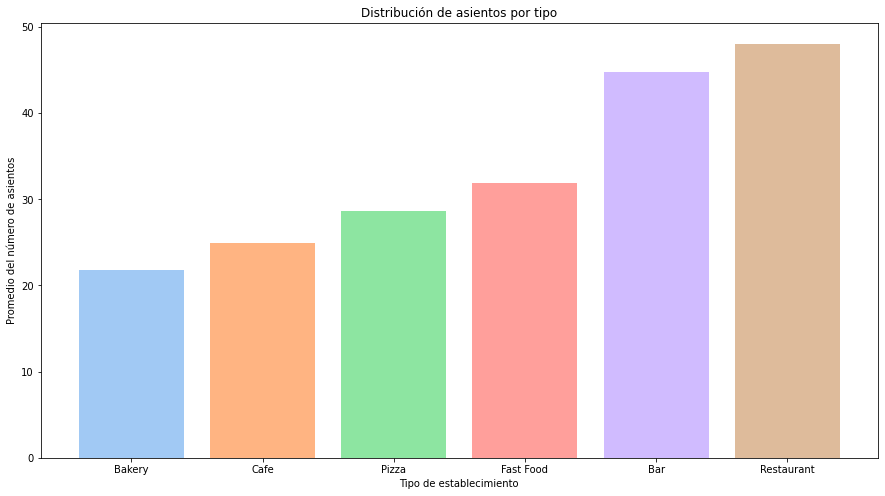

In [30]:
figure(figsize=(15, 8))
colors = sns.color_palette('pastel')
plt.bar(rest_seat_mean['type'], rest_seat_mean['number'], color=colors, label=labels)
plt.title('Distribución de asientos por tipo')
plt.xlabel('Tipo de establecimiento')
plt.ylabel('Promedio del número de asientos')
plt.show()

### **6. Coloca los datos de los nombres de las calles de la columna address en una columna separada**

In [31]:
def extract_street(raw):
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            if (i[1] == 'StreetName') and ('StreetName' in dict_address.keys()):
                text = dict_address[i[1]] + ' ' + i[0] 
                dict_address.update({i[1]:text})            
            else:
                dict_address.update({i[1]:i[0]})
          
        if 'StreetName' in dict_address.keys() :
            street = dict_address['StreetName']
            return street
        else:
            return 'no street'
    

In [32]:
def extract_pre(raw):
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            if (i[1] == 'StreetNamePreDirectional') and ('StreetNamePreDirectional' in dict_address.keys()):
                text = dict_address[i[1]] + ' ' + i[0] 
                dict_address.update({i[1]:text})            
            else:
                dict_address.update({i[1]:i[0]})
          
        if 'StreetNamePreDirectional' in dict_address.keys() :
            street = dict_address['StreetNamePreDirectional']
            return street
        else:
            return ' '

In [33]:
def extract_post(raw):
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            if (i[1] == 'StreetNamePostType') and ('StreetNamePostType' in dict_address.keys()):
                text = dict_address[i[1]] + ' ' + i[0] 
                dict_address.update({i[1]:text})            
            else:
                dict_address.update({i[1]:i[0]})
          
        if 'StreetNamePostType' in dict_address.keys() :
            street = dict_address['StreetNamePostType']
            return street
        else:
            return ' '

In [34]:
rest_data['street_info'] = rest_data['address_clean'].apply(extract_street)
rest_data['street_info2'] = rest_data['address_clean'].apply(extract_pre)
rest_data['street_info3'] = rest_data['address_clean'].apply(extract_post)
rest_data.head(5)

,id,name,address,chain,type,number,name_clean,address_clean,street_info,street_info2,street_info3
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,habitat coffee shop,3708 n eagle rock blvd,eagle rock,n,blvd
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,reillys,100 world way 120,world,,way
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,street churros,6801 hollywood blvd 253,hollywood,,blvd
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 w sunset blvd,sunset,w,blvd
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,pollen,2100 echo park ave,echo park,,ave


In [35]:
rest_data.query('street_info == "no street"')

,id,name,address,chain,type,number,name_clean,address_clean,street_info,street_info2,street_info3
1137,12923,AUNTIE DEES PAN DE MANILA,3756 W AVENUE 40 # #G,False,Restaurant,20,auntie dees pan de manila,3756 w avenue 40 g,no street,w,
1888,13674,MAGDALENO DEBBIE,OLVERA ST E17,False,Restaurant,15,magdaleno debbie,olvera st e17,no street,,
3681,15467,CAFE WG,900 WILSHIRE # 130,False,Restaurant,37,cafe wg,900 wilshire 130,no street,,
3719,15505,LAS ANITAS,OLVERA ST 26,False,Restaurant,38,las anitas,olvera st 26,no street,,
7281,19067,CIELITO LINDO,OLVERA ST 23,False,Restaurant,2,cielito lindo,olvera st 23,no street,,
7319,19105,JUANITA'S CAFE,OLVERA ST 20,False,Restaurant,12,juanitas cafe,olvera st 20,no street,,
7321,19107,KITTY'S SNOW CONES,OLVERA ST 2,False,Restaurant,11,kittys snow cones,olvera st 2,no street,,
7438,19224,LA GOLONDRINA,OLVERA ST W17,False,Restaurant,204,la golondrina,olvera st w17,no street,,
7741,19527,RODOLFO'S RESTAURANT,OLVERA ST 5,True,Restaurant,4,rodolfos restaurant,olvera st 5,no street,,
9241,21027,AMAZEBOWLS,300 S SANTA FE # P,False,Restaurant,25,amazebowls,300 s santa fe p,no street,,


In [36]:
rest_data.at[1137, 'street_info'] = 'avenue'
rest_data.at[1888, 'street_info'] = 'olvera'
rest_data.at[3681, 'street_info'] = 'wilshire'
rest_data.at[3719, 'street_info'] = 'olvera'
rest_data.at[7281, 'street_info'] = 'olvera'
rest_data.at[7319, 'street_info'] = 'olvera'
rest_data.at[7321, 'street_info'] = 'olvera'
rest_data.at[7438, 'street_info'] = 'olvera'
rest_data.at[7741, 'street_info'] = 'olvera'
rest_data.at[9241, 'street_info'] = 'santa fe'
rest_data.query('street_info == "no street"') # Ya no hay "no street" rows en el dataframe después de hacer manual update

,id,name,address,chain,type,number,name_clean,address_clean,street_info,street_info2,street_info3


En esta sección del proyecto hemos creado una columna nueva en la que solamente incluimos el nombre de la calle, el predirectional y post type en columnas separadas. Hubo algunas calles (10) que el la función no logró parsear completamente así que tuvimos que reemplazar el nombre manualmente de "no street" al que sí qera el correcto utilizando el index de la fila en la que se encuentran las calles. Posteriormente juntaremos las 3 columnas de las partes de las direcciones para utilizarla en el análisis posterior.

In [37]:
rest_data['street_good'] = rest_data['street_info2'] + ' ' + rest_data['street_info'] + ' ' + rest_data['street_info3']
rest_data['street_good'] = rest_data['street_good'].str.strip()
rest_data.head(5)

,id,name,address,chain,type,number,name_clean,address_clean,street_info,street_info2,street_info3,street_good
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,habitat coffee shop,3708 n eagle rock blvd,eagle rock,n,blvd,n eagle rock blvd
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,reillys,100 world way 120,world,,way,world way
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,street churros,6801 hollywood blvd 253,hollywood,,blvd,hollywood blvd
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 w sunset blvd,sunset,w,blvd,w sunset blvd
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,pollen,2100 echo park ave,echo park,,ave,echo park ave


### **7. Las diez mejores calles por número de restaurantes**

In [38]:
rest_number = rest_data.pivot_table(index='street_good', values='name', aggfunc='count').sort_values(by='name', ascending=False).reset_index()
top_10 = rest_number.head(10)
top_10

,street_good,name
0,wilshire blvd,381
1,w sunset blvd,368
2,w pico blvd,342
3,s western ave,276
4,santa monica blvd,261
5,hollywood blvd,242
6,w olympic blvd,234
7,w 3rd st,230
8,s figueroa st,225
9,s vermont ave,213


Con esta tabla ahora conocemos las 10 calles con más establecimientos de comida, podemos ver que la calle más popular es Sunset con 403 establecimientos, y abajo podemos observar la distribución de las 10 calles de mayor a menor.

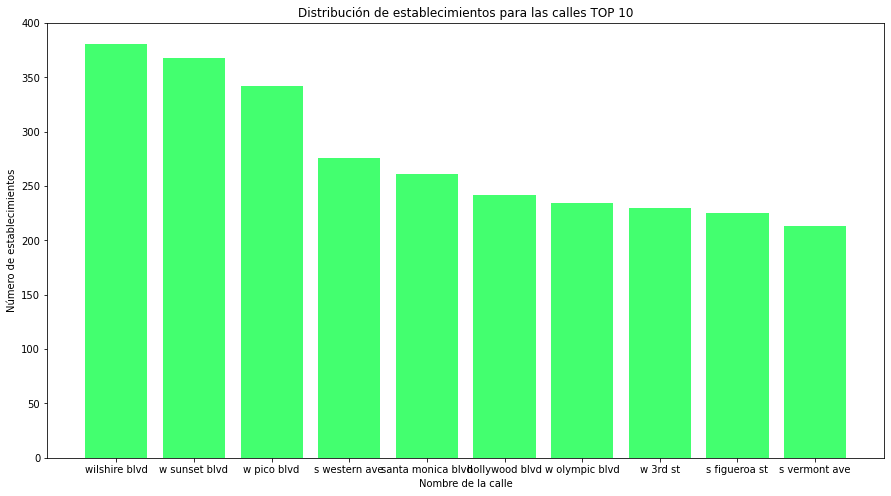

In [39]:
figure(figsize=(15, 8))
plt.bar(top_10['street_good'], top_10['name'], color='#43ff6f')
plt.title('Distribución de establecimientos para las calles TOP 10')
plt.xlabel('Nombre de la calle')
plt.ylabel('Número de establecimientos')
plt.show()

In [40]:
top_10_list = top_10['street_good'].tolist()
top_10_list

['wilshire blvd',
 'w sunset blvd',
 'w pico blvd',
 's western ave',
 'santa monica blvd',
 'hollywood blvd',
 'w olympic blvd',
 'w 3rd st',
 's figueroa st',
 's vermont ave']

### **8. Número de calles que solo tienen un restaurante**

In [41]:
one_rest_st = rest_number.query('name ==1')
print('Hay {:} calles con un sólo restaurante.'.format(len(one_rest_st)))

Hay 365 calles con un sólo restaurante.


In [42]:
print('Hay {:} calles en total que analizamos'.format(len(rest_number)))

Hay 794 calles en total que analizamos


In [43]:
print('El {:.1f}% del total de calles que analizamos sólo cuentan con 1 establecimiento'.format(len(one_rest_st)/len(rest_number)*100))

El 46.0% del total de calles que analizamos sólo cuentan con 1 establecimiento


### **9. Distribución del número de asientos. ¿Qué tendencias puedes ver?**

In [44]:
top_rest_data = rest_data.query('street_good in @top_10_list')
top_rest_data.head(10)

,id,name,address,chain,type,number,name_clean,address_clean,street_info,street_info2,street_info3,street_good
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,street churros,6801 hollywood blvd 253,hollywood,,blvd,hollywood blvd
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,triniti echo park,1814 w sunset blvd,sunset,w,blvd,w sunset blvd
10,11796,EL POLLO LOCO,5319 W SUNSET BLVD,True,Restaurant,38,el pollo loco,5319 w sunset blvd,sunset,w,blvd,w sunset blvd
11,11797,POONG NYUN BAKERY,928 S WESTERN AVE STE 109,True,Bakery,17,poong nyun bakery,928 s western ave ste 109,western,s,ave,s western ave
14,11800,CUSCATLECA BAKERY,2501 W SUNSET BLVD #A,True,Bakery,26,cuscatleca bakery,2501 w sunset blvd a,sunset,w,blvd,w sunset blvd
15,11801,FOOD COURT TRAY WASHING AREA,928 S WESTERN AVE STE 300,True,Restaurant,21,food court tray washing area,928 s western ave ste 300,western,s,ave,s western ave
16,11802,HMS BOUNTY,3357 WILSHIRE BLVD,False,Restaurant,147,hms bounty,3357 wilshire blvd,wilshire,,blvd,wilshire blvd
22,11808,CAMY'S GRILL,3339 WILSHIRE BLVD,False,Restaurant,39,camys grill,3339 wilshire blvd,wilshire,,blvd,wilshire blvd
28,11814,BEVERLY FALAFEL,8508 W 3RD ST,False,Restaurant,31,beverly falafel,8508 w 3rd st,3rd,w,st,w 3rd st
31,11817,DUNES RESTAURANT,5625 W SUNSET BLVD,True,Restaurant,118,dunes restaurant,5625 w sunset blvd,sunset,w,blvd,w sunset blvd


In [45]:
seat_number = rest_data.pivot_table(index='street_good', values='number', aggfunc='sum').sort_values(by='number', ascending=False).reset_index()
top_10_seat = seat_number.head(10)
top_10_seat

,street_good,number
0,wilshire blvd,20018
1,w sunset blvd,17942
2,hollywood blvd,13708
3,w pico blvd,13538
4,w olympic blvd,12079
5,s western ave,11350
6,s figueroa st,11032
7,s vermont ave,9373
8,santa monica blvd,9142
9,w 3rd st,9045


In [46]:
fig = px.histogram(top_rest_data, y="number", x="street_good", color="street_good")
fig.show()

In [47]:
fig = px.histogram(top_rest_data, x='number', nbins = 30, title='Distribución de asientos para los establecimientos de las calles top 10')
fig.show()

Utilizamos la lista top_10_list que contiene las 10 calles con mayor número de establecimientos, y después filtramos nuestro dataframe para realizar un histograma con el número de asientos con los que cuenta cada calle. Ahora tenemos la distribución de asientos para cada una en la gráfica superior. Tenemos en el histograma que hay más establecimientos con pocos asientos, que van de 0-50 asientos, y hay muy pocos establecimientos que tienen más de 60-200 asientos según la distribución.

## **Conclusión**

Del análisis de datos podemos recabar lo siguiente:
 1. Los tipos de establecimiento más abundantes en LA son los restaurantes que no pertenecen a una cadena.
 2.  Tenemos 24% más establecimientos independientes que de cadena.
 3. Hay más asientos en los establecimientos de tipo restaurante que los demás.
 4. Hay más establecimientos con un número de asientos que van de 0-50, que establecimientos con más de 60-200 asientos.
 5. Las calles con mayor número de establecimientos son Sunset, Wilshire y Pico
 6. Las calles que tienen un mayor número de asientos son Hollywood, Sunset y Western.

En cuanto a las cafeterías, la mayoría pertenecen a una cadena y tienen en promedio 24 asientos. Un restaurante independiente sería la opción más popular en general, y una cafetería en cadena sería la opción más popular para este tipo de establecimiento, aunque no hay una diferencia muy grande entre las cafeterías independientes y de cadena. Los robots siendo los meseros sería muy popular al principio y tener una sola sucursal sería la primera opción para ganar cierta popularidad y posteriormente evaluar si abrir más cafeterías y crear una cadena es la mejor opción.